In [15]:
# 라이브러리
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import joblib

In [16]:
# CSV 로드 (체력측정 및 운동처방 종합 데이터) https://www.bigdata-culture.kr/bigdata/user/data_market/detail.do?id=b3924850-aa65-11ec-8ee4-95f65f846b27
files = sorted(glob.glob("data/KS_NFA_FTNESS_MESURE_MVN_PRSCRPTN_GNRLZ_INFO_*.csv"))
print("로드 파일:", files)

로드 파일: ['data\\KS_NFA_FTNESS_MESURE_MVN_PRSCRPTN_GNRLZ_INFO_202503.csv']


In [17]:
df_list = []
for file in files:
    print("로드 중:", file)
    temp = pd.read_csv(file, encoding='utf-8-sig')
    df_list.append(temp)

df = pd.concat(df_list, ignore_index=True)
print("원본 shape:", df.shape)

로드 중: data\KS_NFA_FTNESS_MESURE_MVN_PRSCRPTN_GNRLZ_INFO_202503.csv
원본 shape: (28712, 57)


In [18]:
# 수치형 컬럼 변환
numeric_cols = [
    "MESURE_AGE_CO",
    "MESURE_IEM_001_VALUE", "MESURE_IEM_002_VALUE", "MESURE_IEM_003_VALUE",
    "MESURE_IEM_004_VALUE", "MESURE_IEM_005_VALUE", "MESURE_IEM_006_VALUE",
    "MESURE_IEM_007_VALUE", "MESURE_IEM_008_VALUE", "MESURE_IEM_009_VALUE",
    "MESURE_IEM_010_VALUE", "MESURE_IEM_012_VALUE", "MESURE_IEM_013_VALUE",
    "MESURE_IEM_014_VALUE", "MESURE_IEM_015_VALUE", "MESURE_IEM_016_VALUE",
    "MESURE_IEM_017_VALUE", "MESURE_IEM_018_VALUE", "MESURE_IEM_019_VALUE",
    "MESURE_IEM_020_VALUE", "MESURE_IEM_021_VALUE", "MESURE_IEM_022_VALUE",
    "MESURE_IEM_023_VALUE", "MESURE_IEM_024_VALUE", "MESURE_IEM_025_VALUE",
    "MESURE_IEM_026_VALUE", "MESURE_IEM_027_VALUE", "MESURE_IEM_028_VALUE",
    "MESURE_IEM_029_VALUE", "MESURE_IEM_030_VALUE", "MESURE_IEM_031_VALUE",
    "MESURE_IEM_032_VALUE", "MESURE_IEM_033_VALUE", "MESURE_IEM_034_VALUE",
    "MESURE_IEM_035_VALUE", "MESURE_IEM_036_VALUE", "MESURE_IEM_037_VALUE",
    "MESURE_IEM_038_VALUE", "MESURE_IEM_039_VALUE", "MESURE_IEM_040_VALUE",
    "MESURE_IEM_041_VALUE", "MESURE_IEM_043_VALUE", "MESURE_IEM_044_VALUE",
    "MESURE_IEM_050_VALUE", "MESURE_IEM_051_VALUE", "MESURE_IEM_052_VALUE"
]

In [19]:
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df[df["MESURE_AGE_CO"].between(10, 100)]
df["group"] = (df["MESURE_AGE_CO"] // 10) * 10



# 3. 성별 인코딩
df["F"] = (df["SEXDSTN_FLAG_CD"] == "F").astype(int)
df["M"] = (df["SEXDSTN_FLAG_CD"] == "M").astype(int)

In [20]:
# 15개 운동 라벨 + 난이도 자동 분류
def map_label(text):
    if pd.isna(text):
        return "기타"

    t = text.lower()

    # 난이도
    if "초급" in t:
        level = "초급"
    elif "중급" in t:
        level = "중급"
    elif "고급" in t or "상급" in t:
        level = "고급"
    else:
        level = "일반"

    # 라벨 15종
    if "스트레칭" in t:
        return f"스트레칭({level})"

    if "걷기" in t or "워킹" in t:
        return f"유산소-걷기({level})"

    if "달리기" in t or "조깅" in t or "러닝" in t:
        return f"유산소-달리기({level})"

    if "자전거" in t or "사이클" in t:
        return f"유산소-자전거({level})"

    if any(k in t for k in ["버피", "점프", "전신"]):
        return f"전신유산소({level})"

    if any(k in t for k in ["스쿼트", "런지", "하체"]):
        return f"하체근력({level})"

    if any(k in t for k in ["푸시업", "팔굽", "가슴", "어깨"]):
        return f"상체근력({level})"

    if any(k in t for k in ["플랭크", "코어", "복근"]):
        return f"코어({level})"

    if "요가" in t or "필라테스" in t:
        return f"요가필라테스({level})"

    if "홈트" in t or "full body" in t:
        return f"전신근력({level})"

    return "기타"


df["label"] = df["MVM_PRSCRPTN_CN"].apply(map_label)
df = df[df["label"] != "기타"]

print("라벨 종류:", df["label"].unique())

라벨 종류: ['스트레칭(일반)' '유산소-걷기(일반)' '전신유산소(일반)' '유산소-달리기(일반)' '유산소-자전거(일반)'
 '상체근력(일반)' '요가필라테스(일반)' '하체근력(일반)']


In [21]:
# Feature 구성
feature_cols = [
    "group",
    "MESURE_AGE_CO",
    "F", "M",

    # 체력측정 주요지표
    "MESURE_IEM_001_VALUE",  # 키
    "MESURE_IEM_002_VALUE",  # 체중
    "MESURE_IEM_018_VALUE",  # BMI

    "MESURE_IEM_007_VALUE",  # 악력 좌
    "MESURE_IEM_008_VALUE",  # 악력 우
    "MESURE_IEM_009_VALUE",  # 윗몸말아올리기
    "MESURE_IEM_030_VALUE",  # VO₂max
]

df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df["label"]

In [22]:
# 라벨 인코딩
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [23]:
# 데이터 스플릿
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42
)

In [24]:
model = RandomForestClassifier(
    n_estimators=350,
    max_depth=22,
    min_samples_split=10,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("Macro F1:", f1_score(y_test, pred, average="macro"))
print("Micro F1:", f1_score(y_test, pred, average="micro"))

Accuracy: 0.771264367816092
Macro F1: 0.13141164193812285
Micro F1: 0.771264367816092


In [25]:
# 모델 저장
joblib.dump(model, "exercise_recommender.pkl")
joblib.dump(encoder, "label_encoder.pkl")

print("모델 저장 완료")


모델 저장 완료


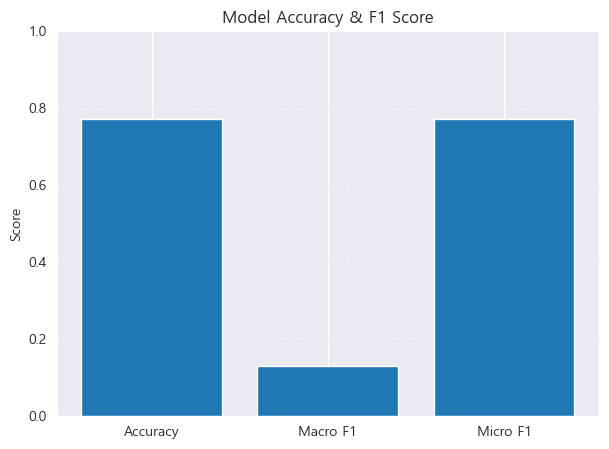

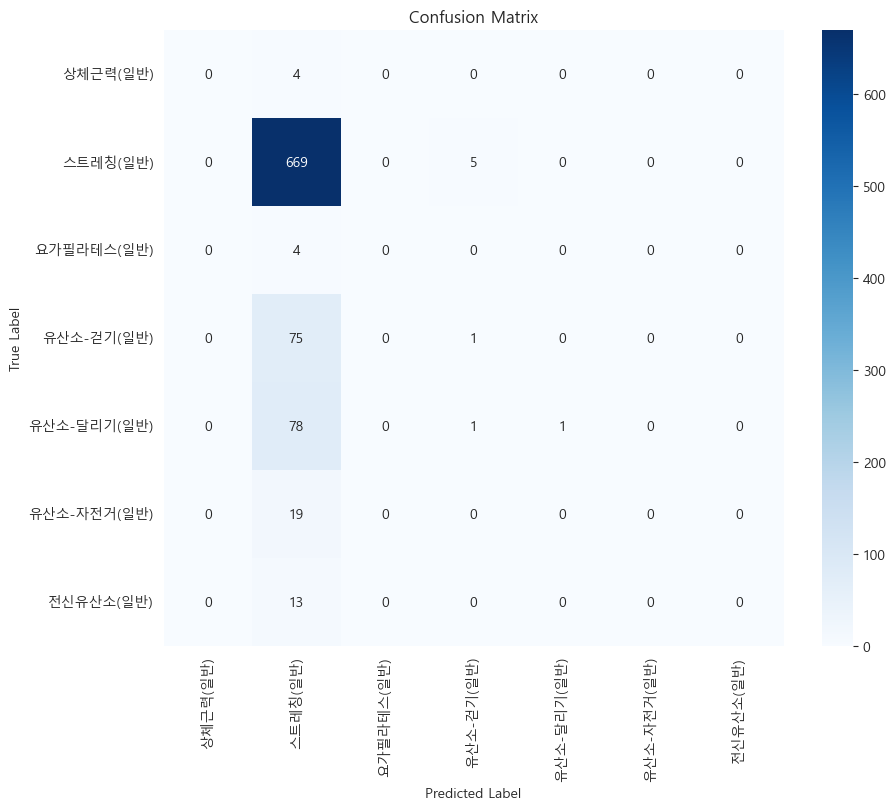

In [26]:
# 정확도 / F1-score 그래프
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 정확도 & F1-score 저장
acc = accuracy_score(y_test, pred)
macro_f1 = f1_score(y_test, pred, average="macro")
micro_f1 = f1_score(y_test, pred, average="micro")

plt.figure(figsize=(7,5))
plt.bar(["Accuracy", "Macro F1", "Micro F1"], [acc, macro_f1, micro_f1])
plt.ylim(0, 1)
plt.title("Model Accuracy & F1 Score")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig("metric_score.png")

# 모델 예측 혼동 행렬
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.savefig("confusion_matrix.png")
plt.show()

##  Model Accuracy & F1 Score 분석

### 1)  Accuracy (정확도) — **0.77**

모델이 전체 테스트 데이터 중 약 **77%**를 올바르게 예측했다는 의미입니다.
→ 즉, **사용자 체력 정보 → 운동 카테고리 예측**이
10개 중 **7~8개는 맞는다**는 수준입니다.

공공데이터의 다양성, 체력 측정값, 운동 종류가 복잡한 상황에서도
꽤 높은 성능이라고 볼 수 있습니다.


---

### 2) ⚠ Macro F1 — **0.13**

Macro F1은 **각 운동 라벨별 F1 score의 평균**입니다.
값이 낮다는 것은 다음을 의미합니다:

- 일부 운동 카테고리는 잘 맞추지만
- **데이터가 적은 운동 카테고리(예: 자전거, 특정 스트레칭 등)는 거의 예측 못함**
- 즉, **데이터 불균형 문제**가 존재함

 예시
- “달리기/걷기/하체근력”처럼 데이터가 많은 라벨 → 잘 예측
- “자전거/상체균형/드물게 등장하는 운동 라벨” → 거의 예측 불가


---

### 3)  Micro F1 — **0.77**

Micro F1은 **전체 데이터를 기준으로 계산한 F1 Score**
Accuracy와 동일하게 약 **0.77 수준**.

→ 즉, **전체적으로는 추천 정확도가 좋다**는 것을 의미합니다.


---

##  한 줄 요약

**Accuracy & Micro F1 (0.77)**
→ 모델은 전반적으로 높은 정확도로 운동을 잘 추천함.

**Macro F1 (0.13)**
→ 운동 종류 중 *데이터가 적은 카테고리는 학습이 덜 된 상태*.
→ 공공데이터 라벨 편중(불균형) 때문.



### 발표용

“우리 모델은 전체 정확도 77%로 사용자에게 안정적인 운동 카테고리를 추천할 수 있습니다.
다만 공공데이터의 운동 종류 불균형 때문에 Macro F1이 낮은데,
이는 운동 종류 중 일부가 데이터가 적어서 생기는 자연스러운 현상입니다.
운동 데이터를 확장하거나 군집 기반 재라벨링을 통해 성능을 추가로 개선할 수 있습니다.”